In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from multi_loc import assimilate, covariance, utilities

In [3]:
%matplotlib inline

# Boorstrapped Hierarchical Filter

Text(0.5, 1.0, 'Background (P)')

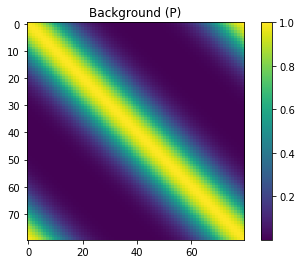

In [4]:
N_state = 80
N_ens = 10
N_ens_ens = 20
rho_0 = 10

H = np.eye(N_state)
# H = H[::2]

N_obs = H.shape[0]

R = np.eye(N_obs)
mu_t = np.zeros(N_state)


P = covariance.generate_circulant(
    Nx=N_state, dx=1, rho0=rho_0,
    correlation_fun=covariance.fft_sqd_exp_1d,
    return_eig=False, return_Corr=True)[0]

plt.figure()
im = plt.imshow(P)
plt.colorbar(im)
plt.title('Background (P)')

In [6]:
X = np.random.multivariate_normal(mu_t, cov=P, size=N_ens)
X = X.T
y = np.random.multivariate_normal(H @ mu_t, cov=R)
Y = y + np.random.multivariate_normal(np.zeros(N_obs), cov=R, size=N_ens)
Y = Y.T

Text(0.5, 1.0, 'Sample Background (P_b)')

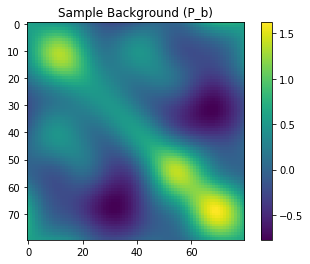

In [8]:
P_sample = np.cov(X)

plt.figure()
im = plt.imshow(P_sample)
plt.colorbar(im)
plt.title('Sample Background (P_b)')

Text(0.5, 1.0, 'Sample K error; L2: 0.5812577524005355')

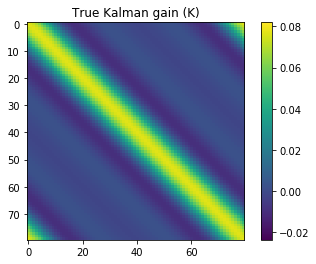

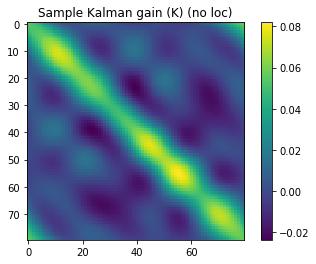

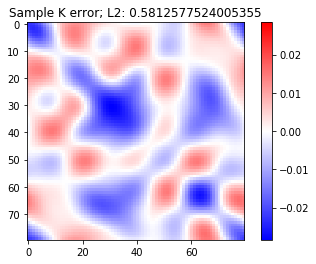

In [9]:
K = P @ H.T @ np.linalg.inv(H @ P @ H.T + R)

K_sample = P_sample @ H.T @ np.linalg.inv(H @ P_sample @ H.T + R)

vmax = np.max([K.max(), K_sample.max()])
vmin = np.min([K.min(), K_sample.min()])

plt.figure()
im = plt.imshow(K,
                vmin=vmin,
                vmax=vmax)
plt.colorbar(im)
plt.title('True Kalman gain (K)')



plt.figure()
im = plt.imshow(K_sample,
                vmin=vmin,
                vmax=vmax)
plt.colorbar(im)
plt.title('Sample Kalman gain (K) (no loc)')

error = K_sample - K
L2 = np.linalg.norm(error, ord=2)
vmax = np.abs(error).max()
plt.figure()
im = plt.imshow(error,
                vmin=-vmax,
                vmax=vmax,
                cmap='bwr')
plt.colorbar(im)
plt.title(f'Sample K error; L2: {L2}')

In [8]:
X_ens = np.ones([N_ens_ens, X.shape[0], X.shape[1]]) * np.nan
P_ens = np.ones([N_ens_ens, P.shape[0], P.shape[1]]) * np.nan
K_ens = np.ones([N_ens_ens, K.shape[0], K.shape[1]]) * np.nan
for n_ee in range(N_ens_ens):
    X_ens[n_ee] = utilities.resample_bootstrap(X)
    P_ens[n_ee] = np.cov(X_ens[n_ee])
    K_ens[n_ee] = (P_ens[n_ee] @ H.T
                   @ np.linalg.inv(
                       H @ P_ens[n_ee] @ H.T + R))

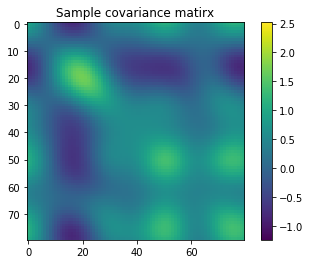

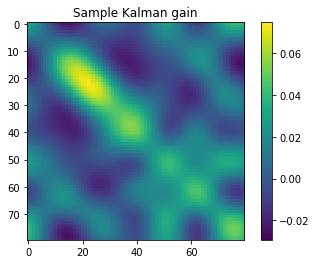

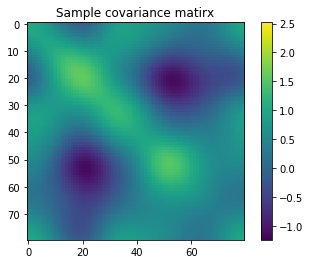

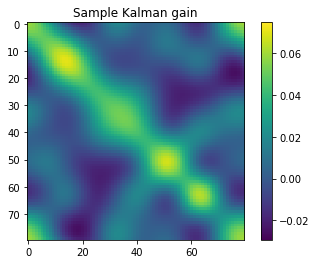

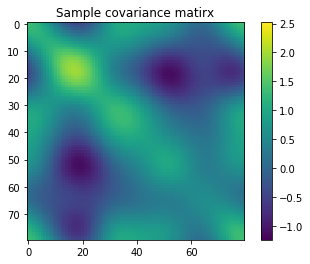

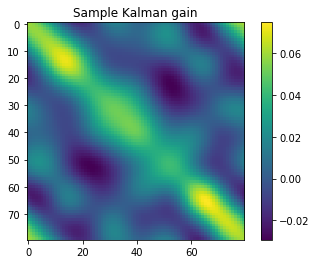

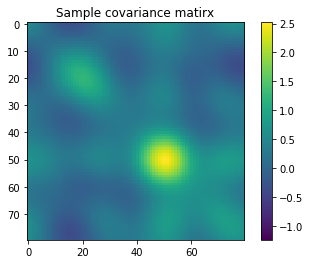

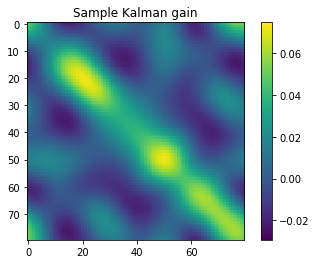

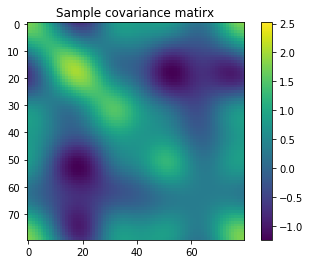

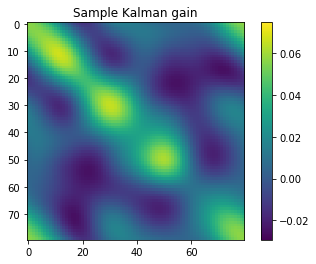

In [9]:
plot_num = 5

P_min = P_ens[:plot_num].min()
P_max = P_ens[:plot_num].max()

K_min = K_ens[:plot_num].min()
K_max = K_ens[:plot_num].max()

for n_ee in range(plot_num):
    plt.figure()
    im = plt.imshow(
        P_ens[n_ee],
        vmin=P_min,
        vmax=P_max)
    plt.colorbar(im)
    plt.title('Sample covariance matirx')
    
    plt.figure()
    im = plt.imshow(
        K_ens[n_ee],
        vmin=K_min,
        vmax=K_max)
    plt.colorbar(im)
    plt.title('Sample Kalman gain')

Text(0.5, 1.0, 'mean Kalman gain')

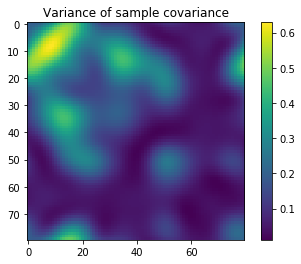

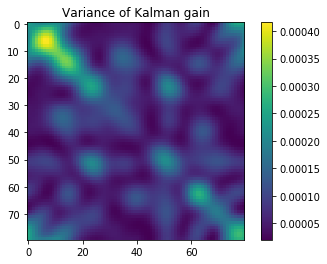

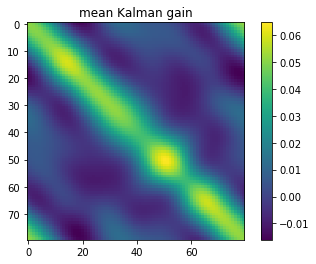

In [10]:
P_var = np.var(P_ens, axis=0)

plt.figure()
im = plt.imshow(P_var)
plt.colorbar(im)
plt.title('Variance of sample covariance')

K_var = np.var(K_ens, axis=0)

plt.figure()
im = plt.imshow(K_var)
plt.colorbar(im)
plt.title('Variance of Kalman gain')

K_mean = np.mean(K_ens, axis=0)

plt.figure()
im = plt.imshow(K_mean)
plt.colorbar(im)
plt.title('mean Kalman gain')

Text(0.5, 1.0, 'sd^2/mean^2')

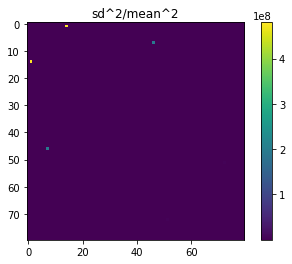

In [11]:
R2 = K_var/K_sample**2

plt.figure()
im = plt.imshow(R2)
plt.colorbar(im)
plt.title('sd^2/mean^2')

Text(0.5, 1.0, 'Kalman gain localization')

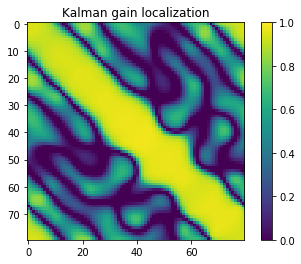

In [12]:
alpha = (1 - R2/(N_ens_ens - 1))/(R2 + 1)
alpha = alpha.clip(min=0)

plt.figure()
im = plt.imshow(alpha,
                vmin=0,
                vmax=1)
plt.colorbar(im)
plt.title('Kalman gain localization')

Text(0.5, 1.0, 'Localized Kalman gain')

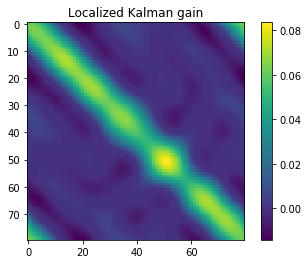

In [13]:
K_loc = alpha * K_sample

plt.figure()
im = plt.imshow(K_loc)
plt.colorbar(im)
plt.title('Localized Kalman gain')

Text(0.5, 1.0, 'Localized K error; L2: 0.38548433167723667')

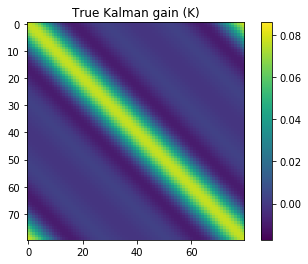

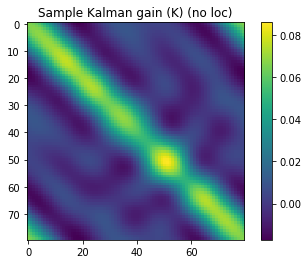

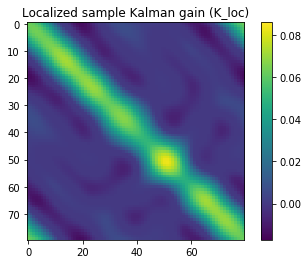

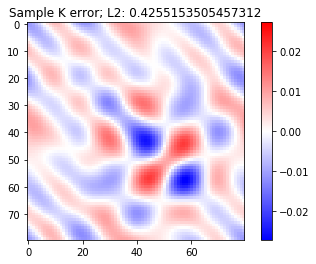

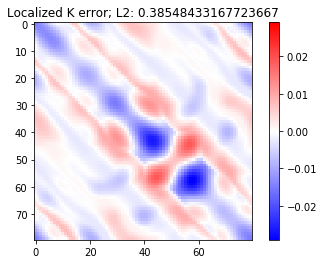

In [14]:
vmax = np.max([K.max(), K_sample.max(), K_loc.max()])
vmin = np.min([K.min(), K_sample.min(), K_loc.min()])

plt.figure()
im = plt.imshow(K,
                vmin=vmin,
                vmax=vmax)
plt.colorbar(im)
plt.title('True Kalman gain (K)')


plt.figure()
im = plt.imshow(K_sample,
                vmin=vmin,
                vmax=vmax)
plt.colorbar(im)
plt.title('Sample Kalman gain (K) (no loc)')

plt.figure()
im = plt.imshow(K_loc,
                vmin=vmin,
                vmax=vmax)
plt.colorbar(im)
plt.title('Localized sample Kalman gain (K_loc)')

error = K_sample - K
L2 = np.linalg.norm(error, ord=2)
vmax = np.abs(error).max()
plt.figure()
im = plt.imshow(error,
                vmin=-vmax,
                vmax=vmax,
                cmap='bwr')
plt.colorbar(im)
plt.title(f'Sample K error; L2: {L2}')

error = K_loc - K
L2 = np.linalg.norm(error, ord=2)
vmax = np.abs(error).max()
plt.figure()
im = plt.imshow(error,
                vmin=-vmax,
                vmax=vmax,
                cmap='bwr')
plt.colorbar(im)
plt.title(f'Localized K error; L2: {L2}')

# Alternative Version

/home/travis/miniconda3/envs/loc/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


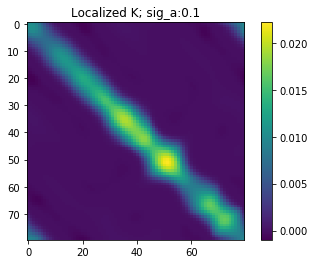

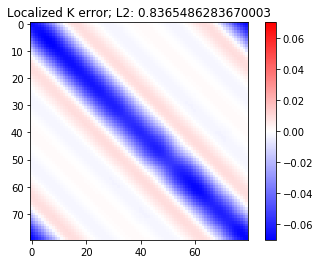

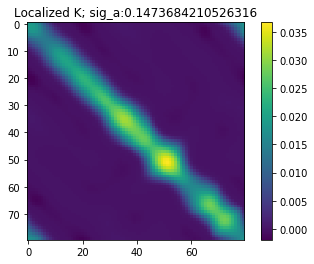

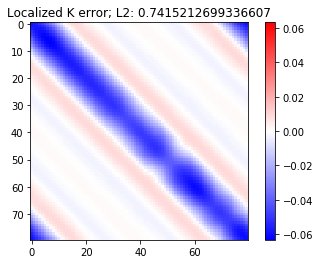

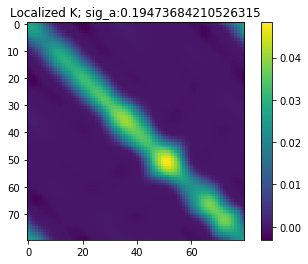

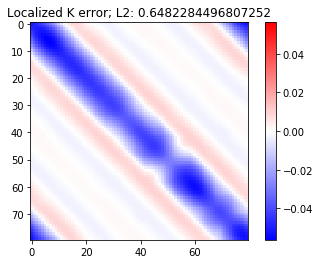

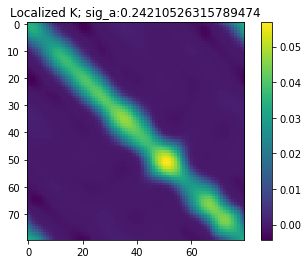

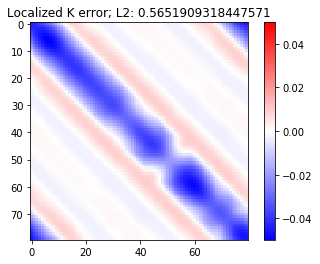

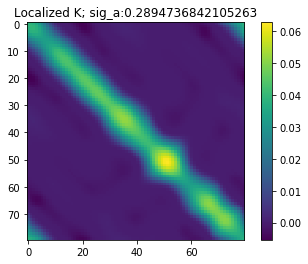

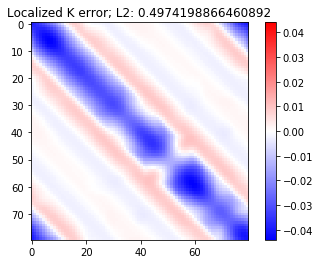

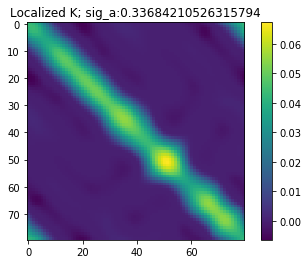

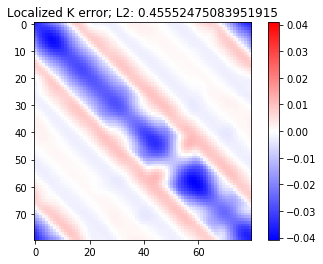

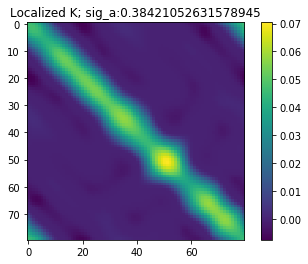

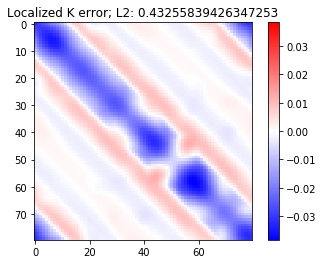

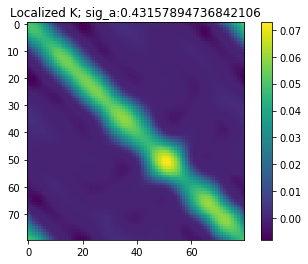

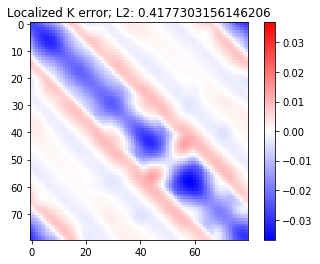

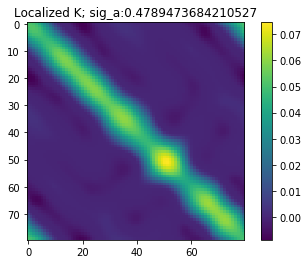

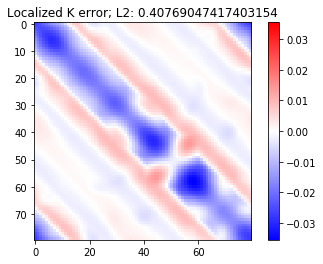

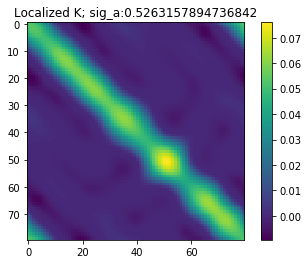

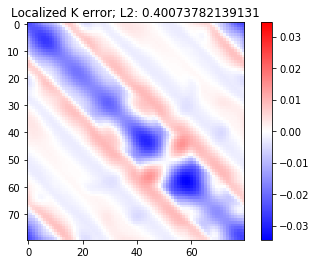

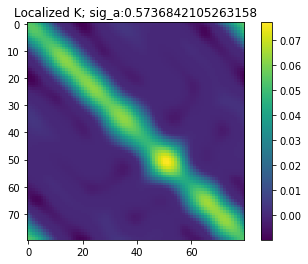

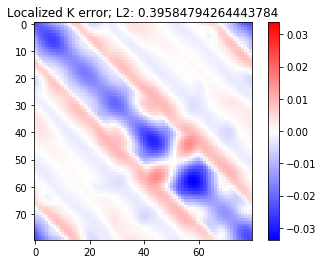

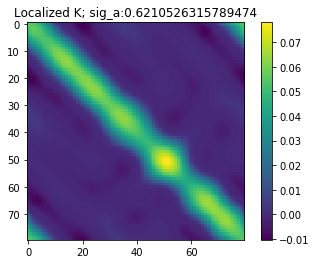

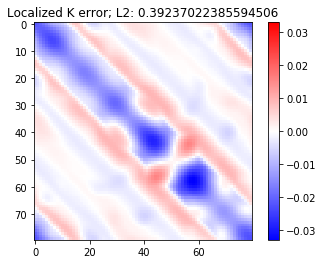

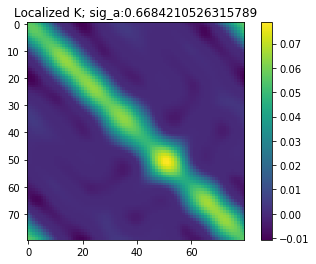

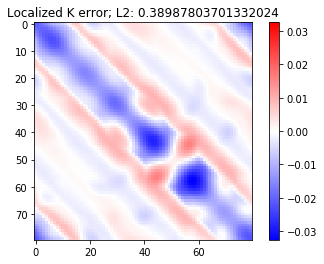

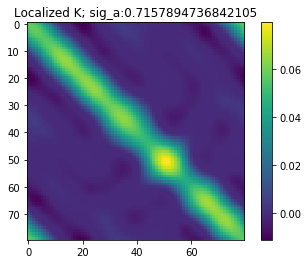

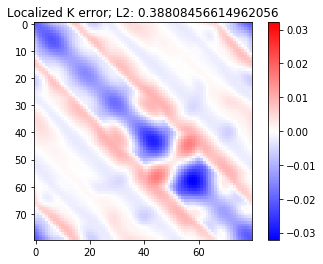

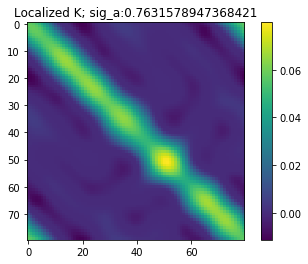

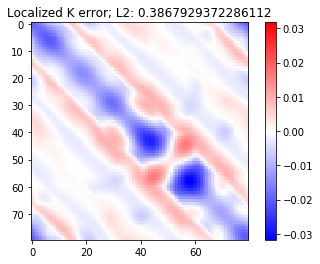

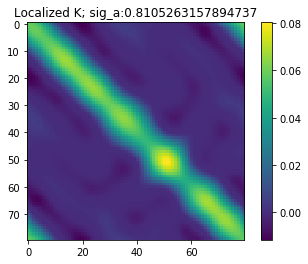

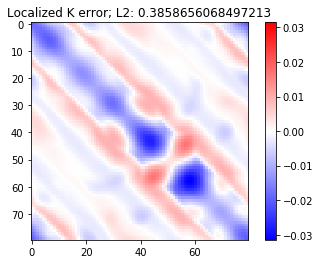

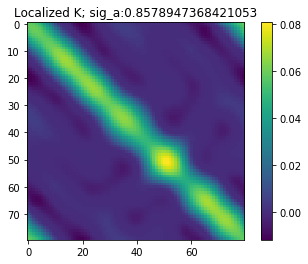

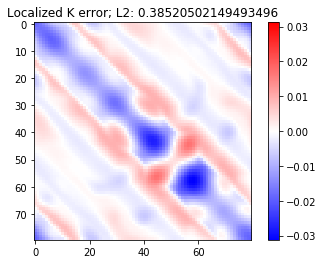

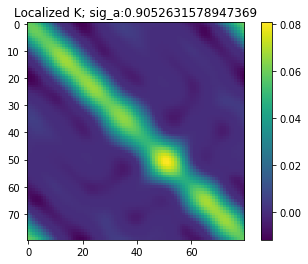

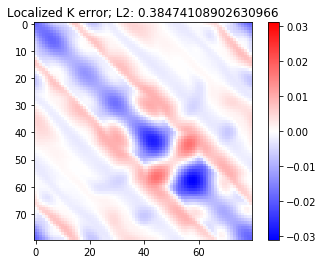

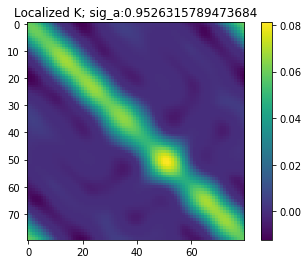

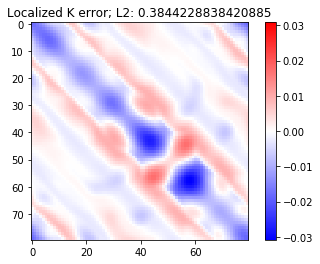

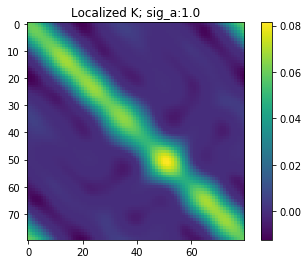

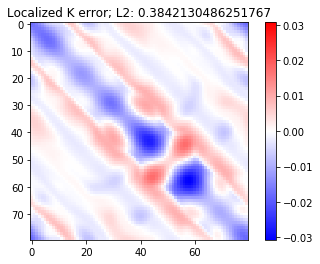

In [15]:
sig_a_array = np.linspace(0.1, 1, 20)
for this_sig_a in sig_a_array:
    alpha = 1/(1 + R2 * (1 + 1/this_sig_a**2))
#     plt.figure()
#     im = plt.imshow(alpha,
#                     vmin=0,
#                     vmax=1)
#     plt.colorbar(im)
#     plt.title(f'Kalman gain localization; sig: {this_sig_a:0.3}')
    
    K_loc = alpha * K_sample
    
    plt.figure()
    im = plt.imshow(K_loc)
    plt.colorbar(im)
    plt.title(
        f'Localized K; sig_a:{this_sig_a}')
    
    error = K_loc - K
    L2 = np.linalg.norm(error, ord=2)
    vmax = np.abs(error).max()
    plt.figure()
    im = plt.imshow(error,
                    vmin=-vmax,
                    vmax=vmax,
                    cmap='bwr')
    plt.colorbar(im)
    plt.title(f'Localized K error; L2: {L2}')

Text(0.5, 1.0, 'Kalman gain localization')

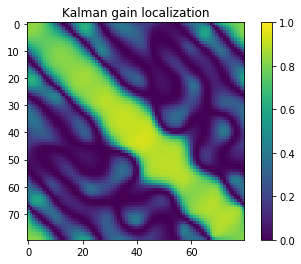

In [16]:
sig_a = 0.6
alpha = 1/(1 + R2 * (1 + 1/sig_a**2))

plt.figure()
im = plt.imshow(alpha,
                vmin=0,
                vmax=1)
plt.colorbar(im)
plt.title('Kalman gain localization')

Text(0.5, 1.0, 'Localized Kalman gain')

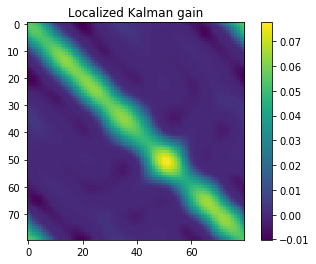

In [17]:
K_loc = alpha * K_sample

plt.figure()
im = plt.imshow(K_loc)
plt.colorbar(im)
plt.title('Localized Kalman gain')

Text(0.5, 1.0, 'Localized K error; L2: 0.39377281506615214')

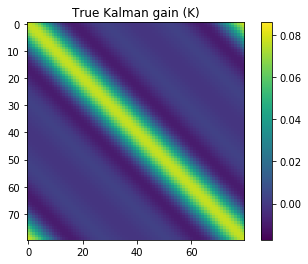

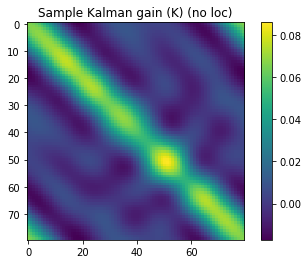

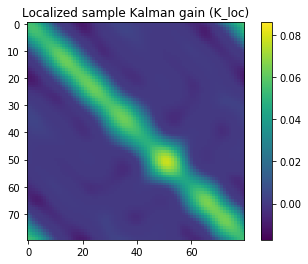

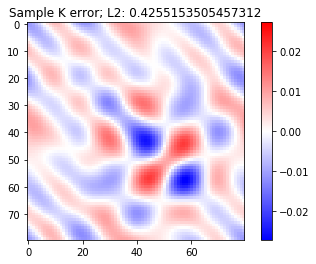

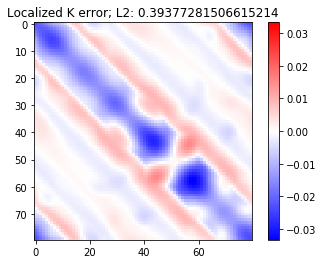

In [18]:
vmax = np.max([K.max(), K_sample.max(), K_loc.max()])
vmin = np.min([K.min(), K_sample.min(), K_loc.min()])

plt.figure()
im = plt.imshow(K,
                vmin=vmin,
                vmax=vmax)
plt.colorbar(im)
plt.title('True Kalman gain (K)')


plt.figure()
im = plt.imshow(K_sample,
                vmin=vmin,
                vmax=vmax)
plt.colorbar(im)
plt.title('Sample Kalman gain (K) (no loc)')

plt.figure()
im = plt.imshow(K_loc,
                vmin=vmin,
                vmax=vmax)
plt.colorbar(im)
plt.title('Localized sample Kalman gain (K_loc)')

error = K_sample - K
L2 = np.linalg.norm(error, ord=2)
vmax = np.abs(error).max()
plt.figure()
im = plt.imshow(error,
                vmin=-vmax,
                vmax=vmax,
                cmap='bwr')
plt.colorbar(im)
plt.title(f'Sample K error; L2: {L2}')

error = K_loc - K
L2 = np.linalg.norm(error, ord=2)
vmax = np.abs(error).max()
plt.figure()
im = plt.imshow(error,
                vmin=-vmax,
                vmax=vmax,
                cmap='bwr')
plt.colorbar(im)
plt.title(f'Localized K error; L2: {L2}')

# Alternative Version: Baysean bootstrap

In [19]:
bootstrap_weights = utilities.bayes_bootstrap_weights(N_ens, N_ens_ens)

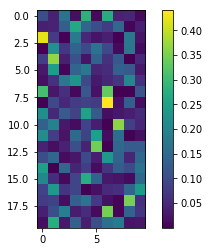

In [20]:
plt.figure()
im = plt.imshow(bootstrap_weights)
plt.colorbar(im)

In [21]:
P_ens = np.ones([N_ens_ens, P.shape[0], P.shape[1]]) * np.nan
K_ens = np.ones([N_ens_ens, K.shape[0], K.shape[1]]) * np.nan
for n_ee in range(N_ens_ens):
    P_ens[n_ee] = np.cov(X_ens[n_ee], aweights=bootstrap_weights[n_ee])
    K_ens[n_ee] = (P_ens[n_ee] @ H.T
                   @ np.linalg.inv(
                       H @ P_ens[n_ee] @ H.T + R))

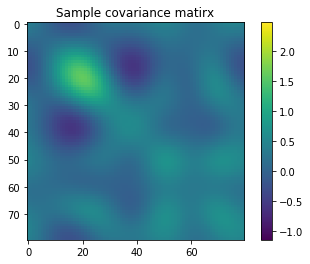

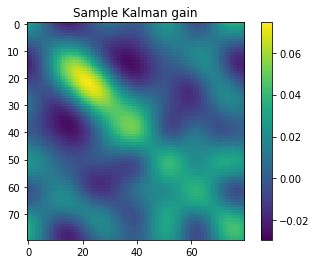

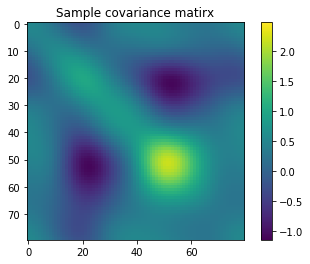

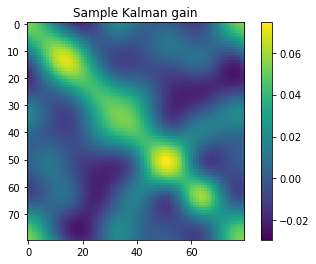

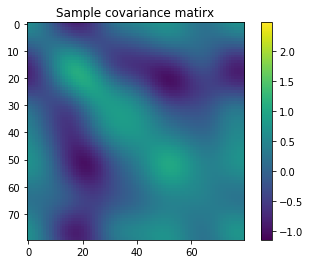

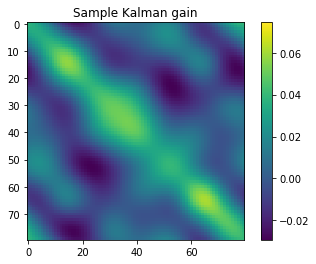

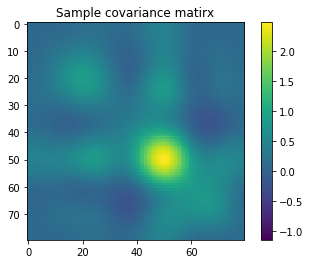

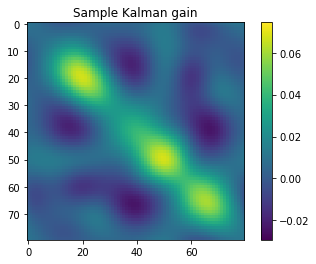

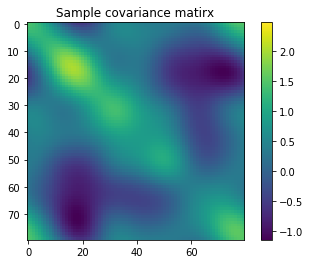

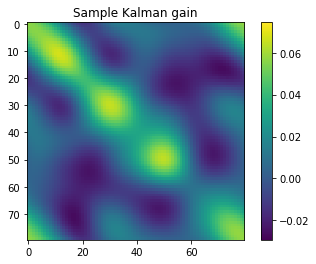

In [22]:
plot_num = 5

P_min = P_ens[:plot_num].min()
P_max = P_ens[:plot_num].max()

K_min = K_ens[:plot_num].min()
K_max = K_ens[:plot_num].max()

for n_ee in range(plot_num):
    plt.figure()
    im = plt.imshow(
        P_ens[n_ee],
        vmin=P_min,
        vmax=P_max)
    plt.colorbar(im)
    plt.title('Sample covariance matirx')
    
    plt.figure()
    im = plt.imshow(
        K_ens[n_ee],
        vmin=K_min,
        vmax=K_max)
    plt.colorbar(im)
    plt.title('Sample Kalman gain')

Text(0.5, 1.0, 'mean Kalman gain')

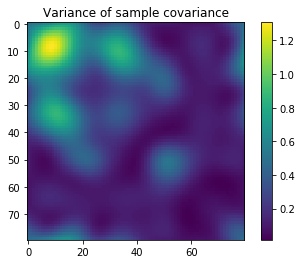

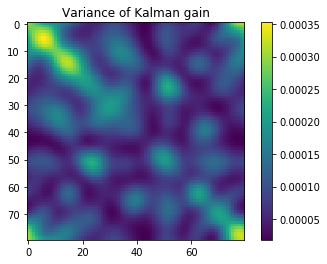

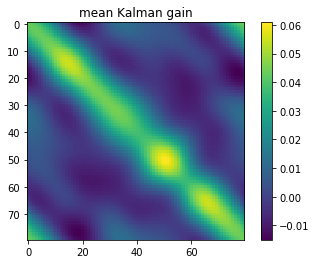

In [23]:
P_var = np.var(P_ens, axis=0)

plt.figure()
im = plt.imshow(P_var)
plt.colorbar(im)
plt.title('Variance of sample covariance')

K_var = np.var(K_ens, axis=0)

plt.figure()
im = plt.imshow(K_var)
plt.colorbar(im)
plt.title('Variance of Kalman gain')

K_mean = np.mean(K_ens, axis=0)

plt.figure()
im = plt.imshow(K_mean)
plt.colorbar(im)
plt.title('mean Kalman gain')

Text(0.5, 1.0, 'sd^2/mean^2')

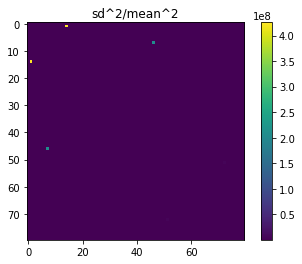

In [24]:
R2 = K_var/K_sample**2

plt.figure()
im = plt.imshow(R2)
plt.colorbar(im)
plt.title('sd^2/mean^2')

Text(0.5, 1.0, 'Kalman gain localization')

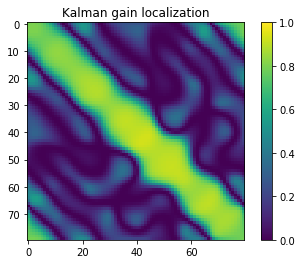

In [25]:
sig_a = 0.6
alpha = 1/(1 + R2 * (1 + 1/sig_a**2))

plt.figure()
im = plt.imshow(alpha,
                vmin=0,
                vmax=1)
plt.colorbar(im)
plt.title('Kalman gain localization')

Text(0.5, 1.0, 'Localized Kalman gain')

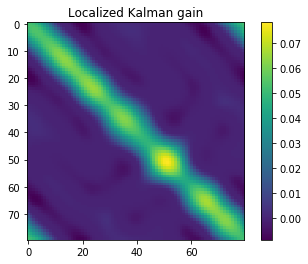

In [26]:
K_loc = alpha * K_sample

plt.figure()
im = plt.imshow(K_loc)
plt.colorbar(im)
plt.title('Localized Kalman gain')

Text(0.5, 1.0, 'Localized K error; L2: 0.3890638526910231')

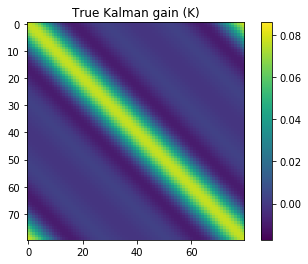

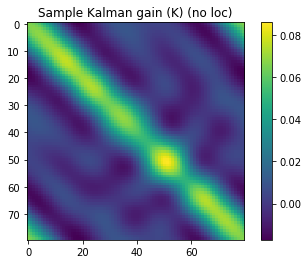

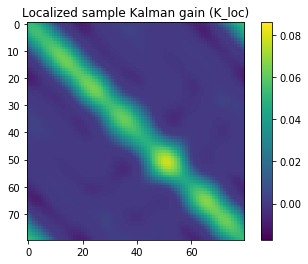

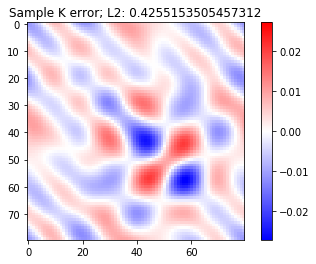

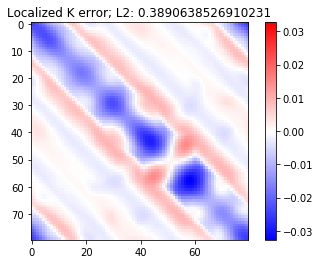

In [27]:
vmax = np.max([K.max(), K_sample.max(), K_loc.max()])
vmin = np.min([K.min(), K_sample.min(), K_loc.min()])

plt.figure()
im = plt.imshow(K,
                vmin=vmin,
                vmax=vmax)
plt.colorbar(im)
plt.title('True Kalman gain (K)')


plt.figure()
im = plt.imshow(K_sample,
                vmin=vmin,
                vmax=vmax)
plt.colorbar(im)
plt.title('Sample Kalman gain (K) (no loc)')

plt.figure()
im = plt.imshow(K_loc,
                vmin=vmin,
                vmax=vmax)
plt.colorbar(im)
plt.title('Localized sample Kalman gain (K_loc)')



error = K_sample - K

L2 = np.linalg.norm(error, ord=2)
vmax = np.abs(error).max()
plt.figure()
im = plt.imshow(error,
                vmin=-vmax,
                vmax=vmax,
                cmap='bwr')
plt.colorbar(im)
plt.title(f'Sample K error; L2: {L2}')

error = K_loc - K

L2 = np.linalg.norm(error, ord=2)
vmax = np.abs(error).max()
plt.figure()
im = plt.imshow(error,
                vmin=-vmax,
                vmax=vmax,
                cmap='bwr')
plt.colorbar(im)
plt.title(f'Localized K error; L2: {L2}')

# Actual ensemble of ensembles

In [10]:
X_ens = np.ones([N_ens_ens, X.shape[0], X.shape[1]]) * np.nan
P_ens = np.ones([N_ens_ens, P.shape[0], P.shape[1]]) * np.nan
K_ens = np.ones([N_ens_ens, K.shape[0], K.shape[1]]) * np.nan
for n_ee in range(N_ens_ens):
    X_temp = np.random.multivariate_normal(mu_t, cov=P, size=N_ens)
    X_ens[n_ee] = X_temp.T
    P_ens[n_ee] = np.cov(X_ens[n_ee])
    K_ens[n_ee] = (P_ens[n_ee] @ H.T
                   @ np.linalg.inv(
                       H @ P_ens[n_ee] @ H.T + R))

In [11]:
P_sample = P_ens[0]
K_smaple = K_ens[0]

Text(0.5, 1.0, 'Sample K error; L2: 0.5812577524005355')

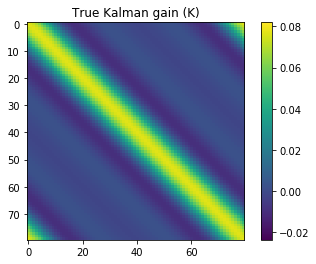

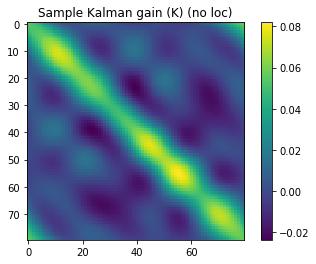

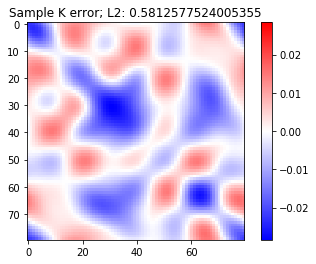

In [12]:
K = P @ H.T @ np.linalg.inv(H @ P @ H.T + R)

vmax = np.max([K.max(), K_sample.max()])
vmin = np.min([K.min(), K_sample.min()])

plt.figure()
im = plt.imshow(K,
                vmin=vmin,
                vmax=vmax)
plt.colorbar(im)
plt.title('True Kalman gain (K)')



plt.figure()
im = plt.imshow(K_sample,
                vmin=vmin,
                vmax=vmax)
plt.colorbar(im)
plt.title('Sample Kalman gain (K) (no loc)')

error = K_sample - K
L2 = np.linalg.norm(error, ord=2)
vmax = np.abs(error).max()
plt.figure()
im = plt.imshow(error,
                vmin=-vmax,
                vmax=vmax,
                cmap='bwr')
plt.colorbar(im)
plt.title(f'Sample K error; L2: {L2}')

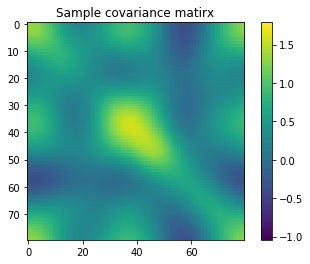

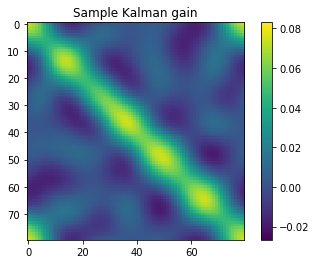

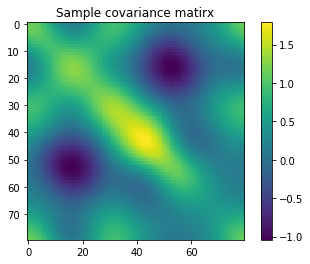

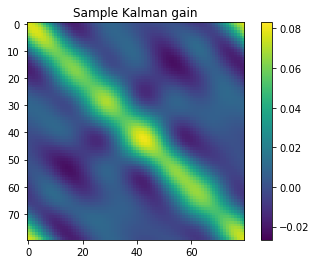

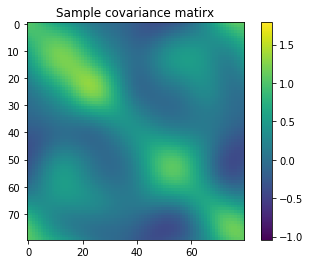

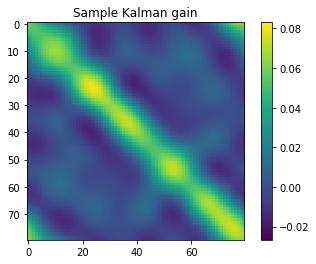

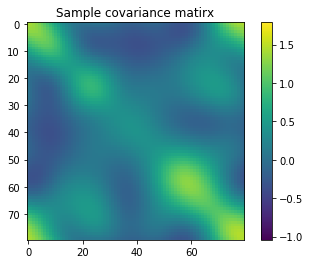

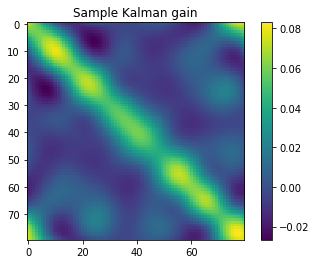

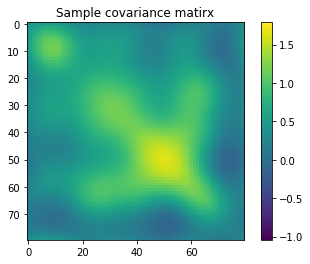

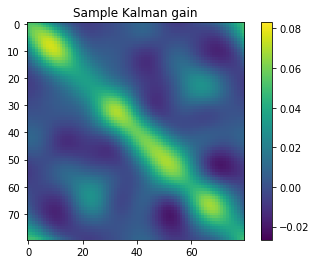

In [13]:
plot_num = 5

P_min = P_ens[:plot_num].min()
P_max = P_ens[:plot_num].max()

K_min = K_ens[:plot_num].min()
K_max = K_ens[:plot_num].max()

for n_ee in range(plot_num):
    plt.figure()
    im = plt.imshow(
        P_ens[n_ee],
        vmin=P_min,
        vmax=P_max)
    plt.colorbar(im)
    plt.title('Sample covariance matirx')
    
    plt.figure()
    im = plt.imshow(
        K_ens[n_ee],
        vmin=K_min,
        vmax=K_max)
    plt.colorbar(im)
    plt.title('Sample Kalman gain')

Text(0.5, 1.0, 'mean Kalman gain')

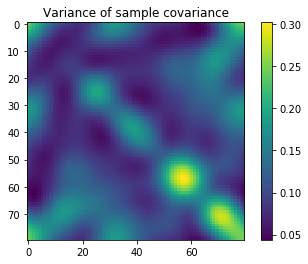

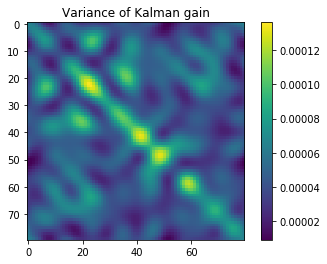

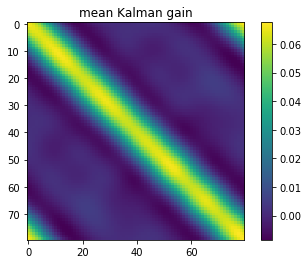

In [14]:
P_var = np.var(P_ens, axis=0)

plt.figure()
im = plt.imshow(P_var)
plt.colorbar(im)
plt.title('Variance of sample covariance')

K_var = np.var(K_ens, axis=0)

plt.figure()
im = plt.imshow(K_var)
plt.colorbar(im)
plt.title('Variance of Kalman gain')

K_mean = np.mean(K_ens, axis=0)

plt.figure()
im = plt.imshow(K_mean)
plt.colorbar(im)
plt.title('mean Kalman gain')

Text(0.5, 1.0, 'sd^2/mean^2')

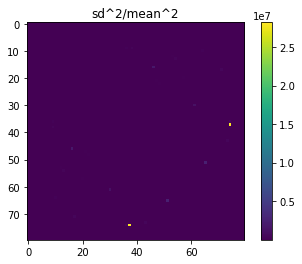

In [15]:
R2 = K_var/K_mean**2

plt.figure()
im = plt.imshow(R2)
plt.colorbar(im)
plt.title('sd^2/mean^2')

Text(0.5, 1.0, 'Kalman gain localization')

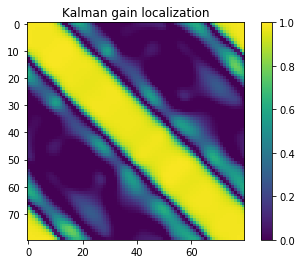

In [16]:
alpha = ((N_ens_ens - R2)/((N_ens_ens - 1) * R2 + N_ens_ens))
alpha = alpha.clip(min=0)

plt.figure()
im = plt.imshow(alpha,
                vmin=0,
                vmax=1)
plt.colorbar(im)
plt.title('Kalman gain localization')

Text(0.5, 1.0, 'Localized Kalman gain')

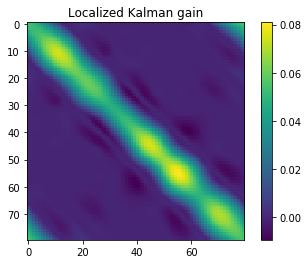

In [17]:
K_loc = alpha * K_sample

plt.figure()
im = plt.imshow(K_loc)
plt.colorbar(im)
plt.title('Localized Kalman gain')

Text(0.5, 1.0, 'Localized K error; L2: 0.3810949985242639')

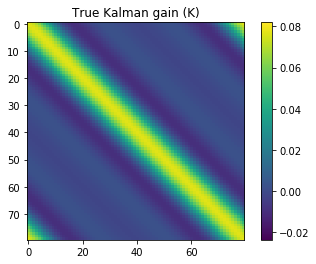

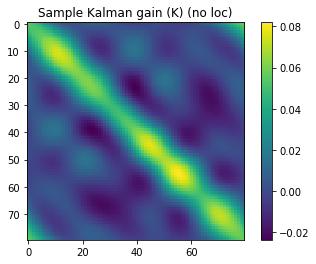

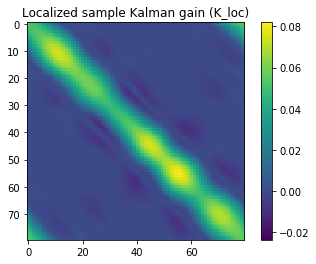

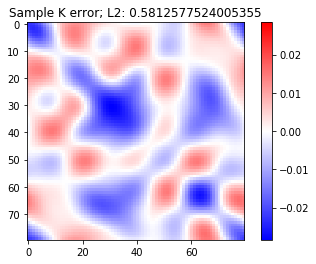

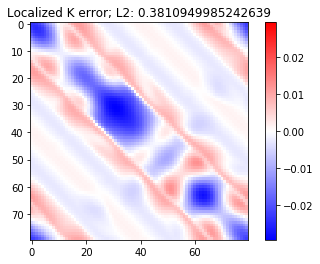

In [18]:
vmax = np.max([K.max(), K_sample.max(), K_loc.max()])
vmin = np.min([K.min(), K_sample.min(), K_loc.min()])

plt.figure()
im = plt.imshow(K,
                vmin=vmin,
                vmax=vmax)
plt.colorbar(im)
plt.title('True Kalman gain (K)')


plt.figure()
im = plt.imshow(K_sample,
                vmin=vmin,
                vmax=vmax)
plt.colorbar(im)
plt.title('Sample Kalman gain (K) (no loc)')

plt.figure()
im = plt.imshow(K_loc,
                vmin=vmin,
                vmax=vmax)
plt.colorbar(im)
plt.title('Localized sample Kalman gain (K_loc)')

error = K_sample - K
L2 = np.linalg.norm(error, ord=2)
vmax = np.abs(error).max()
plt.figure()
im = plt.imshow(error,
                vmin=-vmax,
                vmax=vmax,
                cmap='bwr')
plt.colorbar(im)
plt.title(f'Sample K error; L2: {L2}')

error = K_loc - K
L2 = np.linalg.norm(error, ord=2)
vmax = np.abs(error).max()
plt.figure()
im = plt.imshow(error,
                vmin=-vmax,
                vmax=vmax,
                cmap='bwr')
plt.colorbar(im)
plt.title(f'Localized K error; L2: {L2}')